In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Sat Jan 27 11:26:52 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-5_ze2zq/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

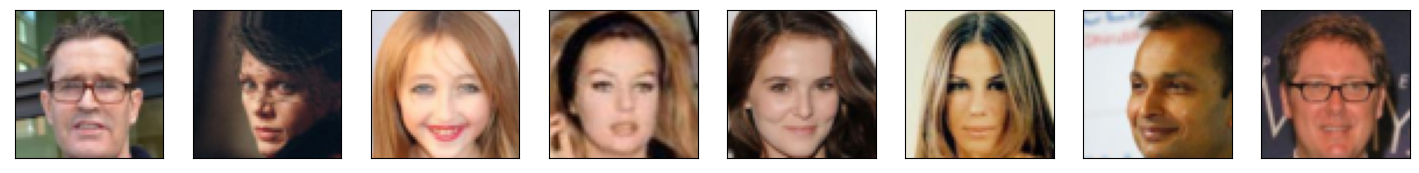

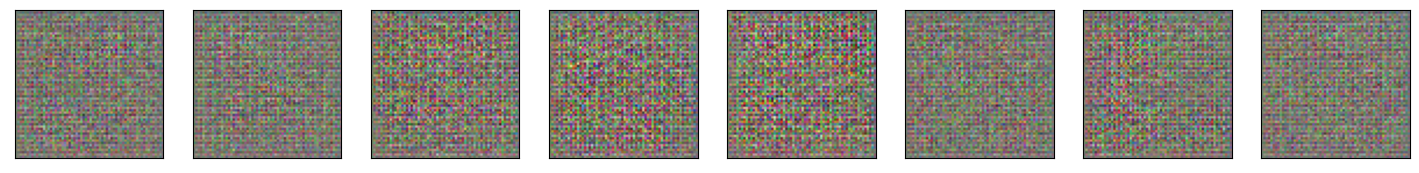

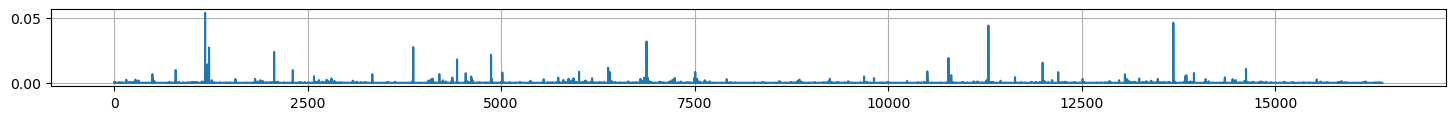

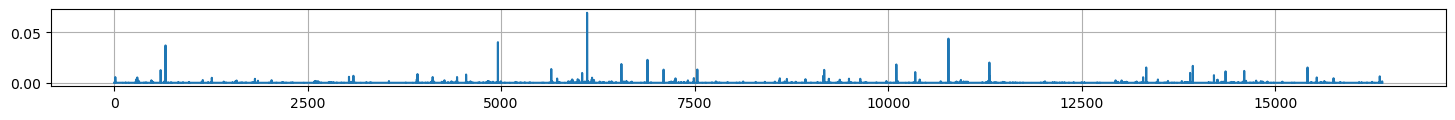

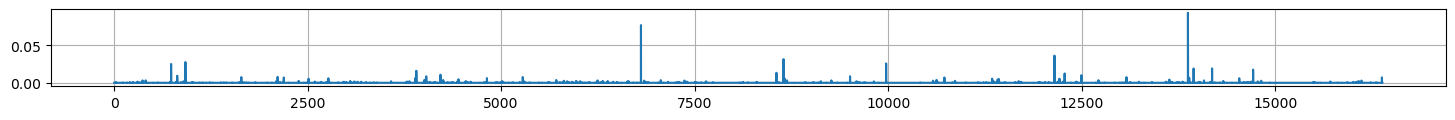

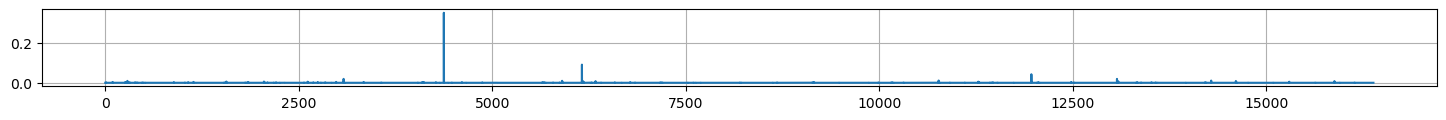

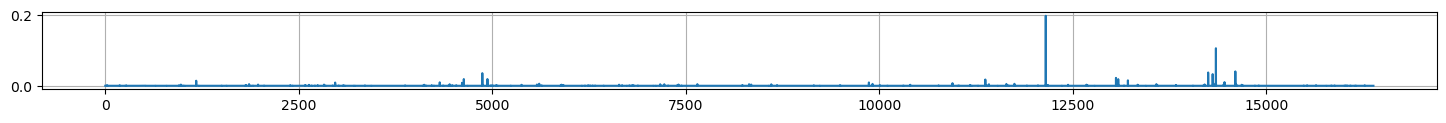

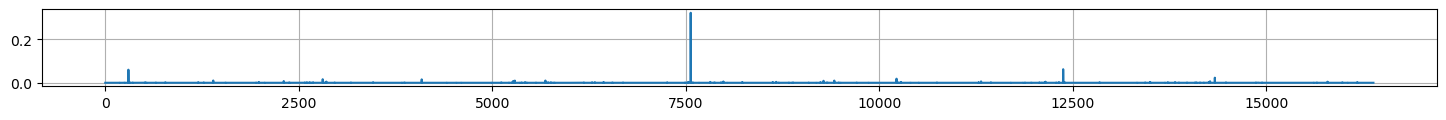

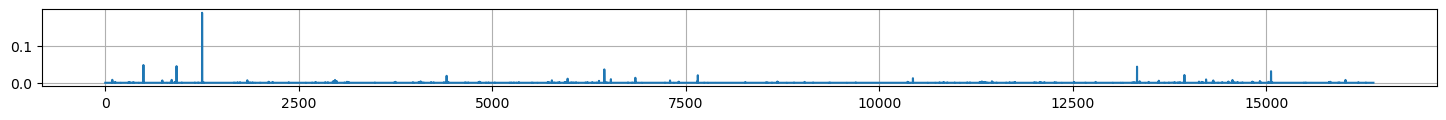

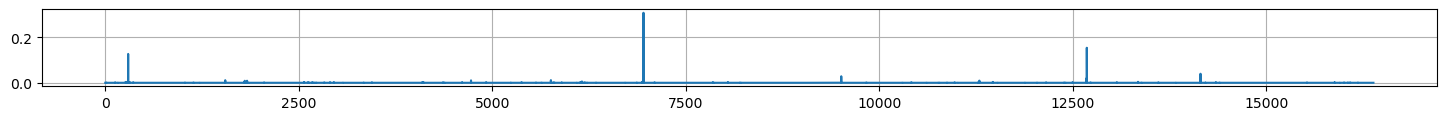

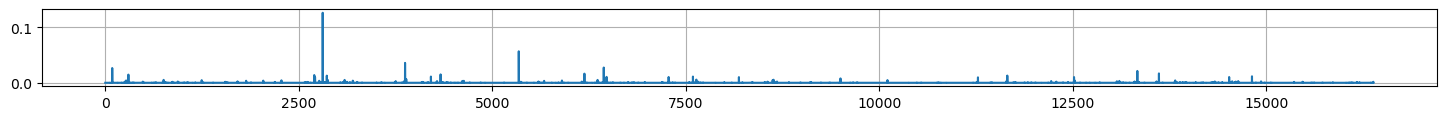

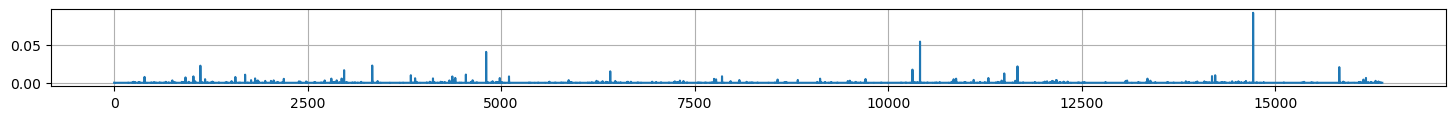

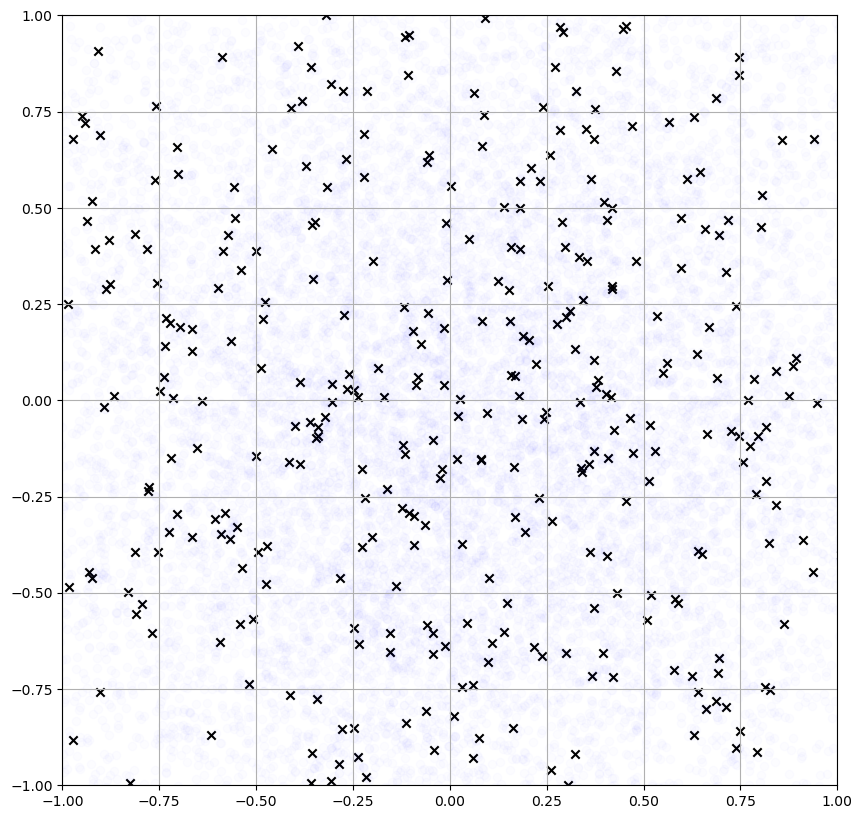

1
lse_loss -8.696433067321777
commit_loss 0.6063368916511536
recon_loss 0.1007104143500328
2
lse_loss -8.683026313781738
commit_loss 0.5933282971382141
recon_loss 0.09288215637207031
3
lse_loss -8.611588478088379
commit_loss 0.5860426425933838
recon_loss 0.08718808740377426
4
lse_loss -8.603392601013184
commit_loss 0.5767005681991577
recon_loss 0.09388548135757446
5
lse_loss -8.757550239562988
commit_loss 0.5572590827941895
recon_loss 0.0894710049033165
6
lse_loss -8.902268409729004
commit_loss 0.5442056059837341
recon_loss 0.0770995169878006
7
lse_loss -8.81662654876709
commit_loss 0.5254918336868286
recon_loss 0.07965252548456192
8
lse_loss -8.679003715515137
commit_loss 0.5123486518859863
recon_loss 0.07598607242107391
9
lse_loss -8.738734245300293
commit_loss 0.4984089434146881
recon_loss 0.07540625333786011
10
lse_loss -8.432551383972168
commit_loss 0.49110594391822815
recon_loss 0.07208159565925598
11
lse_loss -8.401793479919434
commit_loss 0.47760069370269775
recon_loss 0.073189

lse_loss -8.846806526184082
commit_loss 0.36799782514572144
recon_loss 0.02416704222559929
90
lse_loss -8.599457740783691
commit_loss 0.3715970814228058
recon_loss 0.02561064623296261
91
lse_loss -8.71284008026123
commit_loss 0.3716816008090973
recon_loss 0.026782779023051262
92
lse_loss -8.661055564880371
commit_loss 0.36986786127090454
recon_loss 0.023896344006061554
93
lse_loss -8.867127418518066
commit_loss 0.3702101707458496
recon_loss 0.022260669618844986
94
lse_loss -8.7929105758667
commit_loss 0.3709944784641266
recon_loss 0.023587901145219803
95
lse_loss -8.69727611541748
commit_loss 0.3784945607185364
recon_loss 0.023569731041789055
96
lse_loss -8.869929313659668
commit_loss 0.36983174085617065
recon_loss 0.02254948765039444
97
lse_loss -8.678399085998535
commit_loss 0.37438052892684937
recon_loss 0.0225810669362545
98
lse_loss -8.747593879699707
commit_loss 0.3661036193370819
recon_loss 0.02473854087293148
99
lse_loss -8.73787784576416
commit_loss 0.3673858940601349
recon_lo

lse_loss -9.5864896774292
commit_loss 0.3659879267215729
recon_loss 0.014833755791187286
178
lse_loss -9.640250205993652
commit_loss 0.3643900752067566
recon_loss 0.013094853609800339
179
lse_loss -9.507613182067871
commit_loss 0.3658464550971985
recon_loss 0.011902458034455776
180
lse_loss -9.448681831359863
commit_loss 0.36673128604888916
recon_loss 0.013351654633879662
181
lse_loss -9.627936363220215
commit_loss 0.36592286825180054
recon_loss 0.013104645535349846
182
lse_loss -9.706995964050293
commit_loss 0.3579491972923279
recon_loss 0.012969027273356915
183
lse_loss -9.498871803283691
commit_loss 0.36417365074157715
recon_loss 0.013480018824338913
184
lse_loss -9.512791633605957
commit_loss 0.3583538234233856
recon_loss 0.012618282809853554
185
lse_loss -9.361224174499512
commit_loss 0.3624694049358368
recon_loss 0.011903929524123669
186
lse_loss -9.449048042297363
commit_loss 0.36321085691452026
recon_loss 0.013664032332599163
187
lse_loss -9.706583976745605
commit_loss 0.362321

lse_loss -10.200608253479004
commit_loss 0.35001054406166077
recon_loss 0.009561899118125439
265
lse_loss -10.181193351745605
commit_loss 0.35461509227752686
recon_loss 0.009380328468978405
266
lse_loss -10.007342338562012
commit_loss 0.34916770458221436
recon_loss 0.010018615983426571
267
lse_loss -10.14941120147705
commit_loss 0.3537851572036743
recon_loss 0.008294745348393917
268
lse_loss -9.813492774963379
commit_loss 0.35192233324050903
recon_loss 0.009443199262022972
269
lse_loss -9.91894817352295
commit_loss 0.3547678589820862
recon_loss 0.009336588904261589
270
lse_loss -10.310711860656738
commit_loss 0.35330647230148315
recon_loss 0.008585207164287567
271
lse_loss -9.94534969329834
commit_loss 0.35172951221466064
recon_loss 0.009363008663058281
272
lse_loss -10.010357856750488
commit_loss 0.35135191679000854
recon_loss 0.00900265946984291
273
lse_loss -10.100564002990723
commit_loss 0.34833618998527527
recon_loss 0.009256590157747269
274
lse_loss -10.185158729553223
commit_los

lse_loss -10.864615440368652
commit_loss 0.3396795094013214
recon_loss 0.007417729124426842
351
lse_loss -10.855586051940918
commit_loss 0.34433525800704956
recon_loss 0.006864909082651138
352
lse_loss -10.851531028747559
commit_loss 0.34145236015319824
recon_loss 0.006946448236703873
353
lse_loss -10.994956016540527
commit_loss 0.3410901725292206
recon_loss 0.00681624561548233
354
lse_loss -10.85590648651123
commit_loss 0.3431357443332672
recon_loss 0.007349641527980566
355
lse_loss -11.004313468933105
commit_loss 0.3455932140350342
recon_loss 0.006966035813093185
356
lse_loss -10.57775592803955
commit_loss 0.34439587593078613
recon_loss 0.008245332166552544
357
lse_loss -10.897078514099121
commit_loss 0.3464917540550232
recon_loss 0.008717122487723827
358
lse_loss -10.879061698913574
commit_loss 0.3490592837333679
recon_loss 0.007180242799222469
359
lse_loss -11.049086570739746
commit_loss 0.34733712673187256
recon_loss 0.00700691994279623
360
lse_loss -11.131096839904785
commit_loss

438
lse_loss -12.472640037536621
commit_loss 0.33518874645233154
recon_loss 0.0060588642954826355
439
lse_loss -12.094637870788574
commit_loss 0.3334149122238159
recon_loss 0.0060316636227071285
440
lse_loss -12.130925178527832
commit_loss 0.3360476493835449
recon_loss 0.006823169998824596
441
lse_loss -12.609564781188965
commit_loss 0.33678340911865234
recon_loss 0.006227662321180105
442
lse_loss -12.815739631652832
commit_loss 0.33029571175575256
recon_loss 0.006765641272068024
443
lse_loss -12.223721504211426
commit_loss 0.3341103494167328
recon_loss 0.0068592494353652
444
lse_loss -13.394732475280762
commit_loss 0.3347359299659729
recon_loss 0.006603380665183067
445
lse_loss -13.15084171295166
commit_loss 0.3336333632469177
recon_loss 0.006567459087818861
446
lse_loss -12.435683250427246
commit_loss 0.33511149883270264
recon_loss 0.006097945384681225
447
lse_loss -12.944806098937988
commit_loss 0.33801162242889404
recon_loss 0.006533568724989891
448
lse_loss -12.263270378112793
com

lse_loss -13.104973793029785
commit_loss 0.3349694013595581
recon_loss 0.005694631487131119
526
lse_loss -14.87955379486084
commit_loss 0.33184969425201416
recon_loss 0.005981503985822201
527
lse_loss -14.456549644470215
commit_loss 0.33435478806495667
recon_loss 0.005694069899618626
528
lse_loss -14.757010459899902
commit_loss 0.3286856412887573
recon_loss 0.006391276605427265
529
lse_loss -13.193438529968262
commit_loss 0.3324771523475647
recon_loss 0.005765654146671295
530
lse_loss -14.829161643981934
commit_loss 0.33012619614601135
recon_loss 0.005382157396525145
531
lse_loss -14.385466575622559
commit_loss 0.3304254412651062
recon_loss 0.0053573246113955975
532
lse_loss -14.140633583068848
commit_loss 0.33125293254852295
recon_loss 0.005847068037837744
533
lse_loss -14.449904441833496
commit_loss 0.3302150070667267
recon_loss 0.005978628061711788
534
lse_loss -13.073452949523926
commit_loss 0.3314373195171356
recon_loss 0.005625739693641663
535
lse_loss -15.314030647277832
commit_

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp='rand')

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-5
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 